# Submission for the Challenge FOODC

Author - Gaétan Ramet

## Import necessary packages

In [1]:
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
from torchvision import models
import torch.optim as optim
import pandas as pd
import numpy as np
import cv2
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

## Loading Data
In pytorch we can directly load our files into torchvision(the library which creates the object) or create a custom class to load data. The class must have `__init__` , `__len__` and `__getitem__` functions. We create a custom dataloader to suit our needs. More info on custom loaders can be read [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [2]:
class FoodData(Dataset):
    def __init__(self,data_list,data_dir = './',transform=None,train=True):
        super().__init__()
        self.data_list = data_list
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
    
    def __len__(self):
        return self.data_list.shape[0]
    
    def __getitem__(self,item):
        if self.train:
          img_name,label = self.data_list.iloc[item]
        else:
          img_name = self.data_list.iloc[item]['ImageId']
        img_path = os.path.join(self.data_dir,img_name)
        img = cv2.imread(img_path,1)
        img = cv2.resize(img,(256,256))
        if self.transform is not None:
            img = self.transform(img)
        if self.train:
          return {
              'gt' : img,
              'label' : torch.tensor(label)

          }
        else:
          return {
              'gt':img
          }
        

We first convert the data labels into encodings using Label Encoders. This basically converts labels into number encodings. This is an important step as without it we cannot train our network

In [3]:
train = pd.read_csv('train.csv')
le = preprocessing.LabelEncoder()
targets = le.fit_transform(train['ClassName'])
ntrain = train
ntrain['ClassName'] = targets
print(ntrain)

ImageId  ClassName
0     f27632d7e5.jpg         55
1     efa87919ed.jpg         41
2     4f169e8c8d.jpg         12
3     a6956654bf.jpg         44
4     d99ce8c3bf.jpg         23
...              ...        ...
9318  ba8233c7d2.jpg          7
9319  2090043907.jpg         58
9320  8762d1cefd.jpg         14
9321  28e7439245.jpg         12
9322  ba263cfb41.jpg         21

[9323 rows x 2 columns]


We load our train data and some necessary augementations like converting to PIL image, converting to tensors and normalizing them across channels. We can add more augementations such as `Random Flip`, `Random Rotation`, etc more on which can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html)

In [4]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=180, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))
])
train_path = 'data/train/train_images'
train_data = FoodData(data_list= ntrain,data_dir = train_path,transform = transforms_train)

## EDA
Let us do some exploratory data analysis. The idea is to see the class distribution, how the images are and much more. 

In [5]:
train = pd.read_csv('train.csv')
nums = train['ClassName'].value_counts()
classes = train['ClassName'].unique()
print("Percentage of each class")
for cl in classes:
  print(cl,'\t',nums[cl]/train.shape[0]*100,"%")

Percentage of each class
water 	 9.25667703528907 %
pizza-margherita-baked 	 1.179877721763381 %
broccoli 	 0.9009975329829454 %
salad-leaf-salad-green 	 5.738496192212807 %
egg 	 2.2417676713504235 %
butter 	 3.71125174300118 %
bread-white 	 6.382065858629196 %
apple 	 2.0486967714255067 %
dark-chocolate 	 0.9439021774107046 %
white-coffee-with-caffeine 	 1.3085916550466588 %
sweet-pepper 	 0.9009975329829454 %
mixed-salad-chopped-without-sauce 	 1.8127212270728308 %
tomato-sauce 	 1.179877721763381 %
cucumber 	 1.1476992384425615 %
cheese 	 1.4694840716507562 %
pasta-spaghetti 	 1.040437627373163 %
rice 	 2.7458972433765956 %
zucchini 	 0.9653544996245843 %
salmon 	 0.5470342164539311 %
mixed-vegetables 	 2.542100182344739 %
espresso-with-caffeine 	 2.0916014158532663 %
banana 	 1.9414351603561086 %
strawberries 	 0.9331760163037649 %
mayonnaise 	 0.4612249275984125 %
almonds 	 0.740105116378848 %
bread-wholemeal 	 4.269012120562051 %
wine-white 	 1.619650327147914 %
hard-cheese 	 1.

We observe that water is the most popular class although the distribution is not that skewed. Let us plot the images of white flour french bread and french fries and have a look at the kind of images we have

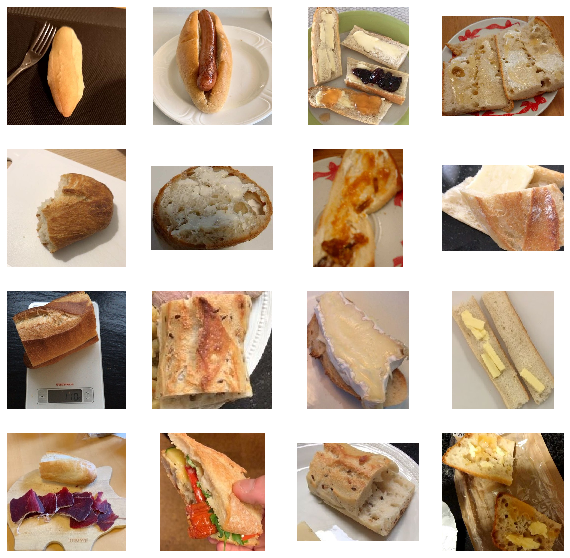

In [6]:
imgs = train.loc[train['ClassName'] == 'bread-french-white-flour']
plt.figure(figsize=(10,10))
for i in range(imgs[:16].shape[0]):
  path = imgs.iloc[i]['ImageId']
  image = cv2.imread(os.path.join(train_path,path),1)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  plt.subplot(4,4,i+1)
  plt.axis('off')
  plt.imshow(image)

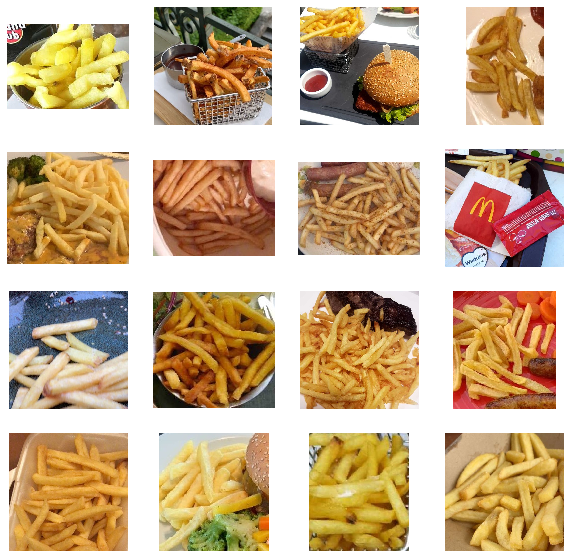

In [7]:
imgs = train.loc[train['ClassName'] == 'chips-french-fries']
plt.figure(figsize=(10,10))
for i in range(imgs[:16].shape[0]):
  path = imgs.iloc[i]['ImageId']
  image = cv2.imread(os.path.join(train_path,path),1)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  plt.subplot(4,4,i+1)
  plt.axis('off')
  plt.imshow(image)

## Split Data into Train and Validation
Now we want to see how well our model is performing, but we dont have the test data labels with us to check. What do we do ? So we split our dataset into train and validation. The idea is that we test our classifier on validation set in order to get an idea of how well our classifier works. This way we can also ensure that we dont [overfit](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/) on the train dataset. There are many ways to do validation like [k-fold](https://machinelearningmastery.com/k-fold-cross-validation/),[leave one out](https://en.wikipedia.org/wiki/Cross-validation_(statistics), etc  

We also make `dataloaders` which basically create minibatches of dataset which are used in each epoch

In [8]:
batch = 128
valid_size = 0.2
num = train_data.__len__()
# Dividing the indices for train and cross validation
indices = list(range(num))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num))
train_idx,valid_idx = indices[split:], indices[:split]

#Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size = batch, sampler = train_sampler)
valid_loader = DataLoader(train_data, batch_size = batch, sampler = valid_sampler)


Here we load test images. Note: This file will not have any labels with it

In [9]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5))
])
test_path = 'data/test/test_images'
test = pd.read_csv('test.csv')
test_data = FoodData(data_list= test,data_dir = test_path,transform = transforms_test,train=False)

test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)


Here we check if we have a GPU or not. If we have we just need to shift our data and model to GPU for faster computations.

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
    

cuda:0


## Define the Model
Now we come to the juicy part. We define our model here. We need to create a class with `__init__` and `forward` functions which define the layers and forward pass respectively. We can also load pretrained models and freeze their layers and add more layers on top of it, to train them. More on pretrained models with pytorch [here](https://pytorch.org/docs/stable/torchvision/models.html) and making models [here](https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/).

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
  # Define layers here
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)

    def forward(self, x):
      # Forward pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 61 * 61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



Here we define our model object along with our optimizer and error function. Typically for multi class classification we use `Cross Entropy Loss`. More about different types of losses are [here](https://pytorch.org/docs/stable/nn.html#loss-functions).   
We use the popular Adam optimizer with its default parameters. There are other optimizers like `SGD`, `RMSPROP`, `Adamax`,etc. You can have a detailed look at optimizers [here](https://pytorch.org/docs/stable/optim.html)

In [12]:
model = Net().to(device)
class_weight = torch.zeros(len(classes))
for cl in classes:
    class_weight[cl] = nums[cl] / max(nums)
error = nn.CrossEntropyLoss(weight=class_weight).to(device)
optimizer = optim.Adam(model.parameters())

TypeError: 'numpy.ndarray' object is not callable

## Train 
Alright enough talk and time to train. We define the number of epochs and train the model. An epoch is a forward pass and backward pass of all the data points. An epoch consists of iterations which depend on batch size. So basically we take a batch, get its output, do a backward pass and let the optimizer take a step. This is the workflow for any pytorch code.  
## Validate
Now after an epoch ends, we check with validation and do the same steps except backward pass on loss and optimizer step. If we get a reduction in validation loss, we save the model. This is sort of an early stopping.

In [13]:
n_epochs = 50
valid_loss_min = np.Inf

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for images in train_loader:
        data = images['gt'].squeeze(0).to(device)
        # data = data.squeeze(0)
        target = images['label'].to(device)
#             clear the gradients of all optimized variables
        optimizer.zero_grad()
#         forward pass the model
        output = model(data)
#     backward pass the model
        loss = error(output,target)
        loss.backward()
#         Perform a single optimization step
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    
    
    
    model.eval()
    for images in valid_loader:
        data = images['gt'].squeeze(0).to(device)
        target = images['label'].to(device)
#         forward pass now
        output = model(data)
#         calculate the branch loss
        loss = error(output, target)
#     update average validation loss
        valid_loss += loss.item()*data.size(0)
    
    train_loss /= len(train_loader.sampler)
    valid_loss /= len(valid_loader.sampler)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print("Validation Loss decreased {:0.6f} -> {:0.6f}".format(valid_loss_min,valid_loss))
        valid_loss_min = valid_loss
        torch.save(model.state_dict(), 'best_model_so_far.pth')

NameError: name 'optimizer' is not defined

## Predict on Validation
Now we predict our trained model on the validation set and evaluate our model

In [14]:
model.load_state_dict(torch.load('best_model_so_far.pth'))
model.eval()
correct = 0
total = 0
pred_list = []
correct_list = []
with torch.no_grad():
    for images in valid_loader:
        data = images['gt'].squeeze(0).to(device)
        target = images['label'].to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        pr = predicted.detach().cpu().numpy()
        for i in pr:
          pred_list.append(i)
        tg = target.detach().cpu().numpy()
        for i in tg:
          correct_list.append(i)
        correct += (predicted == target).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

RuntimeError: Error(s) in loading state_dict for Net:
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 3, 5, 5]) from checkpoint, the shape in current model is torch.Size([16, 3, 5, 5]).
	size mismatch for conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for conv2.weight: copying a param with shape torch.Size([32, 64, 5, 5]) from checkpoint, the shape in current model is torch.Size([16, 16, 5, 5]).
	size mismatch for conv2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([400, 119072]) from checkpoint, the shape in current model is torch.Size([120, 59536]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([120]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([250, 400]) from checkpoint, the shape in current model is torch.Size([84, 120]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([250]) from checkpoint, the shape in current model is torch.Size([84]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([61, 250]) from checkpoint, the shape in current model is torch.Size([61, 84]).

## Evaluate the Performance
We use the same metrics as that will be used for the test set.  
[F1 score](https://en.wikipedia.org/wiki/F1_score) and [Log Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) are the metrics for this challenge

In [15]:
from sklearn.metrics import f1_score,precision_score,log_loss   
print("F1 score :",f1_score(correct_list,pred_list,average='micro'))

NameError: name 'correct_list' is not defined

## Predict on test set
Time for the moment of truth! Predict on test set and time to make the submission.

In [16]:
model.load_state_dict(torch.load('best_model_so_far.pth'))
model.eval()

preds = []
with torch.no_grad():
    for images in test_loader:
        data = images['gt'].squeeze(0).to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        pr = predicted.detach().cpu().numpy()
        for i in pr:
          preds.append(i)


RuntimeError: Error(s) in loading state_dict for Net:
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 3, 5, 5]) from checkpoint, the shape in current model is torch.Size([16, 3, 5, 5]).
	size mismatch for conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for conv2.weight: copying a param with shape torch.Size([32, 64, 5, 5]) from checkpoint, the shape in current model is torch.Size([16, 16, 5, 5]).
	size mismatch for conv2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([400, 119072]) from checkpoint, the shape in current model is torch.Size([120, 59536]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([120]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([250, 400]) from checkpoint, the shape in current model is torch.Size([84, 120]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([250]) from checkpoint, the shape in current model is torch.Size([84]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([61, 250]) from checkpoint, the shape in current model is torch.Size([61, 84]).

## Save it in correct format

In [17]:
# Create Submission file        
df = pd.DataFrame(le.inverse_transform(preds),columns=['ClassName'])
df.to_csv('submission.csv',index=False)

NameError: name 'preds' is not defined